In [1]:
# Import Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Astropy for FITS handling and modeling
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy import modeling

# Model fitting
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from astropy.modeling import models, fitting
from astropy import modeling
from lmfit.models import SkewedGaussianModel

# Import Pandas to work with AFS algorithm
import pandas as pd

# Import Scipy and Numpy derivative works
import scipy.optimize
from scipy.signal import savgol_filter
from scipy.misc import derivative
from numpy import diff

# Import Numpy Integration
from numpy import trapz

# Import Models for Fitting
from lmfit.models import GaussianModel, SkewedGaussianModel, VoigtModel

# Import Time
import time

# Import to Work Across Files
import os

# Access HPC Files
from glob import glob

In [2]:
# Choose Graph and Plotting Style
plt.style.use(['ggplot'])

In [3]:
# Define Path for Noon Files
path = '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/'
glob(path+'*')

['/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210528T194658.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210302T192010.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210110T194341.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210323T192318.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210204T193723.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210112T195346.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210626T194331.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210605T192351.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210213T192536.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210530T192230.fits',
 '/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20201225T194058.fits',
 '/xdisk/cbender/cben

In [4]:
# Open FITS File
hdul = fits.open('/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210509T195226.fits')
hdul.info()

Filename: /xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/neidL2_20210509T195226.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     746   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float32   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float32   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float32   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2085   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2085   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2085   (9216, 122)   float64   
 10  TELLURIC      1 ImageHDU        12   (9216, 122)   float64   
 11  SKY           1 ImageHDU         8   ()      
 12  CCFS          1 ImageHDU       515   (804, 122)   float64   
 13  

In [5]:
# Get Flux and Wave Data
wave = hdul['SCIWAVE'].data
flux = hdul['SCIFLUX'].data

# Print Flux and Wave Data Shape 
print('Flux Data Shape:', flux.shape)
print('Wave Data Shape:', wave.shape) # both have 122 spectral orders!

Flux Data Shape: (122, 9216)
Wave Data Shape: (122, 9216)


In [6]:
# Universal Graph Styling
COLOR = 'k'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update({'figure.max_open_warning': 0})

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


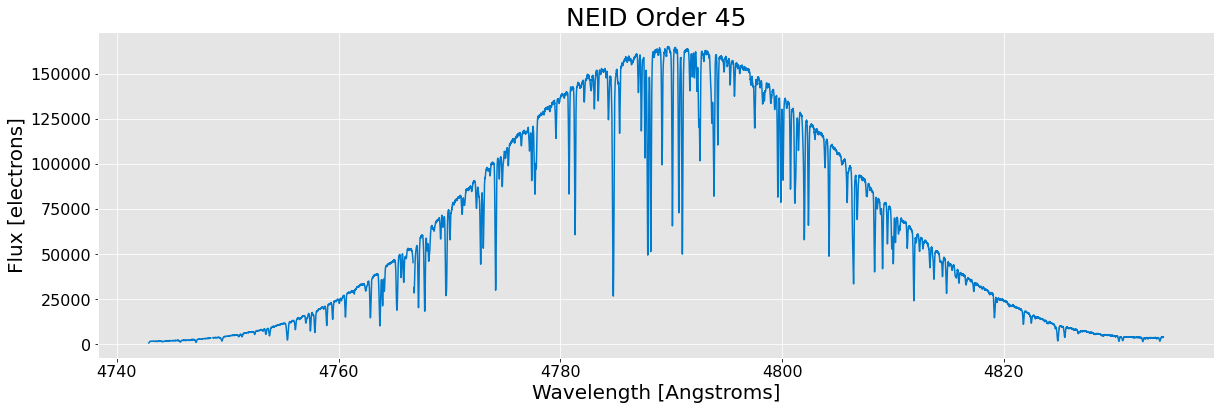

In [7]:
# Working with Order 48 First (40-110)
order = 45
x = wave[order,:]
y = flux[order,:]
pix_array = np.arange(flux.shape[1])

# Set NaNs to zero
#flux[np.isnan(flux)] = 0
#telluric[np.isnan(telluric)] = 0

# Plot Order 50
plt.figure(figsize=(20,6))
plt.plot(x,y, color='#007acc')
plt.title('NEID Order {}'.format(order), fontsize=25)
plt.xlabel('Wavelength [Angstroms]', fontsize=20)
plt.ylabel('Flux [electrons]', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [8]:
def chunked_continuum_fit(x, y, percentile_cut=95.0, nchunks=15, deg=5):
    chunks_x = np.zeros(nchunks) #Chunk up spectrum and store mini-spectrum chunks in lists
    chunks_y = np.zeros(nchunks)
    npixels = len(x)
    pixels_per_chunk = npixels / nchunks
    for i in range(nchunks): #Loop through each chunk
        chunk_i1 = np.int(i*pixels_per_chunk)
        chunk_i2 = np.int((i+1)*pixels_per_chunk)
        if chunk_i2 > npixels: #Chop end of last chunk
            chunk_i2 = npixels
        chunks_y[i] = np.nanpercentile(y[chunk_i1:chunk_i2], percentile_cut) #Chunk y is xxth percentile of chunk
        chunks_x[i] = 0.5*(x[chunk_i1:chunk_i2][0]+x[chunk_i1:chunk_i2][-1]) #Chunk x is just center of chunk
    smooth_y = savgol_filter(chunks_y, 11, 1) # add some smoothin to avoid "falling" into lines
    pfit = np.polyfit(chunks_x, smooth_y, deg=deg) #fit polynomial to chunks
    cs = CubicSpline(chunks_x, chunks_y)
    return np.polyval(pfit, x), cs, chunks_x, chunks_y #Return continuum array generated from polynomial fit

In [9]:
unkfit, cs,chunks_x, chunks_y = chunked_continuum_fit(pix_array,flux[order,:],percentile_cut=90.0, nchunks=100, deg=7)
model = SkewedGaussianModel()

# set initial parameter values
params = model.make_params(amplitude=2e5, center=4500, sigma=1000, gamma=1)

# adjust parameters  to best fit data.
result = model.fit(chunks_y, params, x=chunks_x)
skew_blaze = np.interp(pix_array, chunks_x, result.best_fit)

correction = flux[order,:]/skew_blaze

Text(0, 0.5, 'Normalized Intensity')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


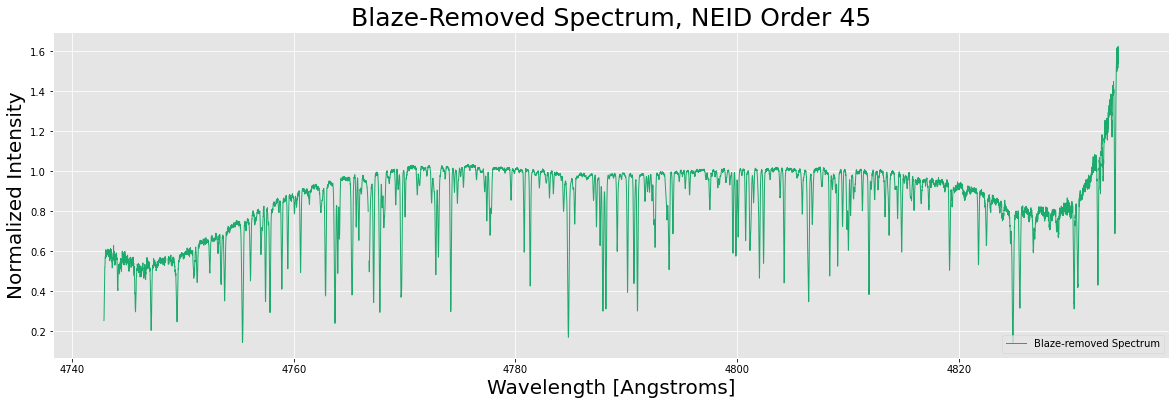

In [10]:
plt.figure(figsize=(20,6))
plt.plot(x, correction, 'b', linewidth=1, label='Blaze-removed Spectrum', color='#1DAB6D')
plt.legend(loc='lower right')
plt.title('Blaze-Removed Spectrum, NEID Order {}'.format(order), fontsize=25)
plt.xlabel('Wavelength [Angstroms]', fontsize=20)
plt.ylabel('Normalized Intensity', fontsize=20)

In [11]:
# First Derivative of Blaze-Removed Spectrum (To Find Zero-Crossings)
derivative = np.gradient(correction)

# Second Derivative of Blaze-Removed Spectrum (To Remove Most Noise)
derivative2 = np.gradient(derivative) 

# Smoothed First & Second Derivatives
smooth_derivative = savgol_filter(derivative, 11, 5)
smooth_derivative2 = savgol_filter(derivative2, 11, 5)

# Third Derivative of Blaze-Removed Spectrum (To Remove Duplicate Points)
derivative3 = np.gradient(smooth_derivative2) 

# Sort List to Split into 3 Parts and Find Avg Value of Upper Part to determine 2nd Der 'Bump' Thresholds
sortedlist_for2 = np.sort(smooth_derivative2)
splitlist = np.array_split(sortedlist_for2, 3)
print(splitlist[2])

# Second Derivative 'Bump' Threshhold
print('2nd Derivative Threshold: ', np.mean(splitlist[2]))

# Find Zero Crossings
zero_crossing1 = np.where((smooth_derivative2 > np.mean(splitlist[2])))[0] 
zero_crossing2 = np.where(np.diff(np.signbit(derivative3)))

zerolist1 = zero_crossing1.tolist()
zerolist2 = np.array(zero_crossing2).tolist()
zero_crossings = np.array(list(set(zerolist1).intersection(zerolist2[0]))) # final list of points!

[0.00050825 0.00050832 0.00050842 ...        nan        nan        nan]
2nd Derivative Threshold:  nan


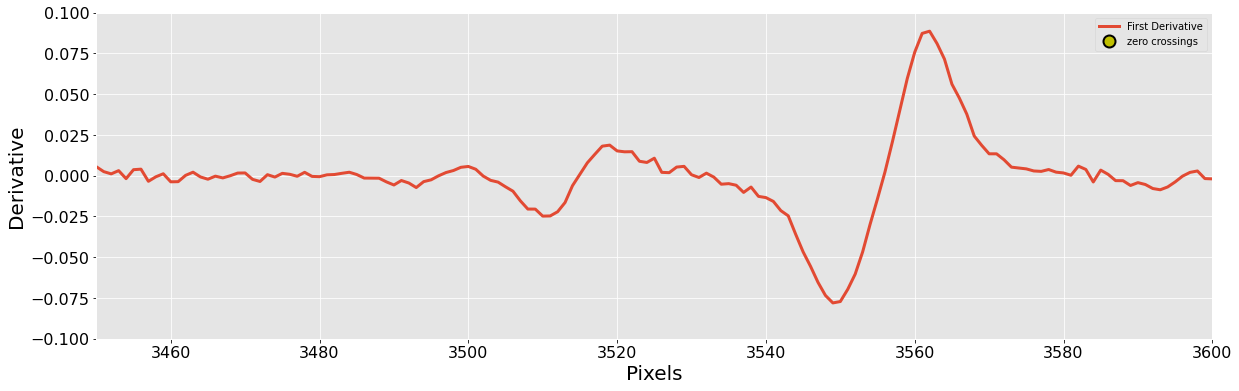

In [12]:
# Plot the First Derivative between pixels 1350 and 1500 for Analysis
plt.figure(figsize=(20,6))
plt.plot(derivative,lw=3,label='First Derivative')
plt.plot(zero_crossings,np.zeros(len(zero_crossings)),'yo',ms=12,markeredgecolor='k',
         markeredgewidth=2,label='zero crossings')
plt.xlim(3450,3600) 
plt.ylim(-0.1,0.1)
plt.xlabel('Pixels', fontsize=20)
plt.ylabel('Derivative', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

plt.show()

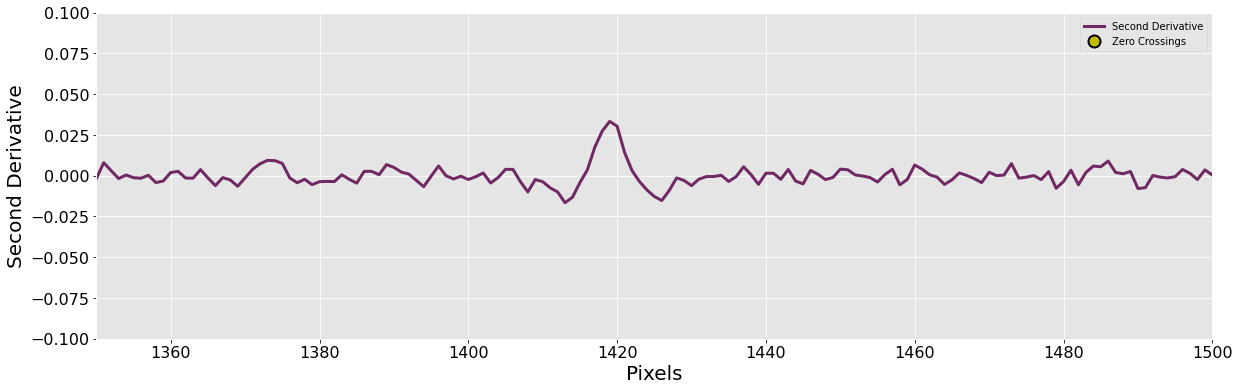

In [13]:
# Plot the Second Derivative between pixels 1350 and 1500 for Analysis
plt.figure(figsize=(20,6))
plt.plot(derivative2,lw=3,label='Second Derivative', color='#702963')
plt.plot(zero_crossings,np.zeros(len(zero_crossings)),'yo',ms=12,markeredgecolor='k',
         markeredgewidth=2,label='Zero Crossings')
plt.xlim(1350,1500)
plt.ylim(-0.1,0.1)
plt.xlabel('Pixels', fontsize=20)
plt.ylabel('Second Derivative', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

plt.show()

In [14]:
# Create List of Peak Findings and Sort List
good_lines = []
for zero_crossing in zero_crossings:
    # (Arpita) cut off pixels at very edge of detector
    if 20 < zero_crossing < 9000: 
        
        # (Arpita) Make sure first derivate is going from negative to positive
        slope = smooth_derivative[zero_crossing-1] - smooth_derivative[zero_crossing+1]
        
        # (Arpita) Im setting these numbers after experimenting with different slope cuts
        if -0.38 < slope < -0.01:
            good_lines.append(zero_crossing)
good_lines.sort()

# Delete Really Close-to-Each-Other Values
for index, i in enumerate(good_lines):
    if good_lines[-1] == i:
        break
        
    i_up = good_lines[index+1]
    if ((i_up-i) < 18):
        good_lines.remove(i)
        good_lines.remove(i_up)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


List of peak findings: []


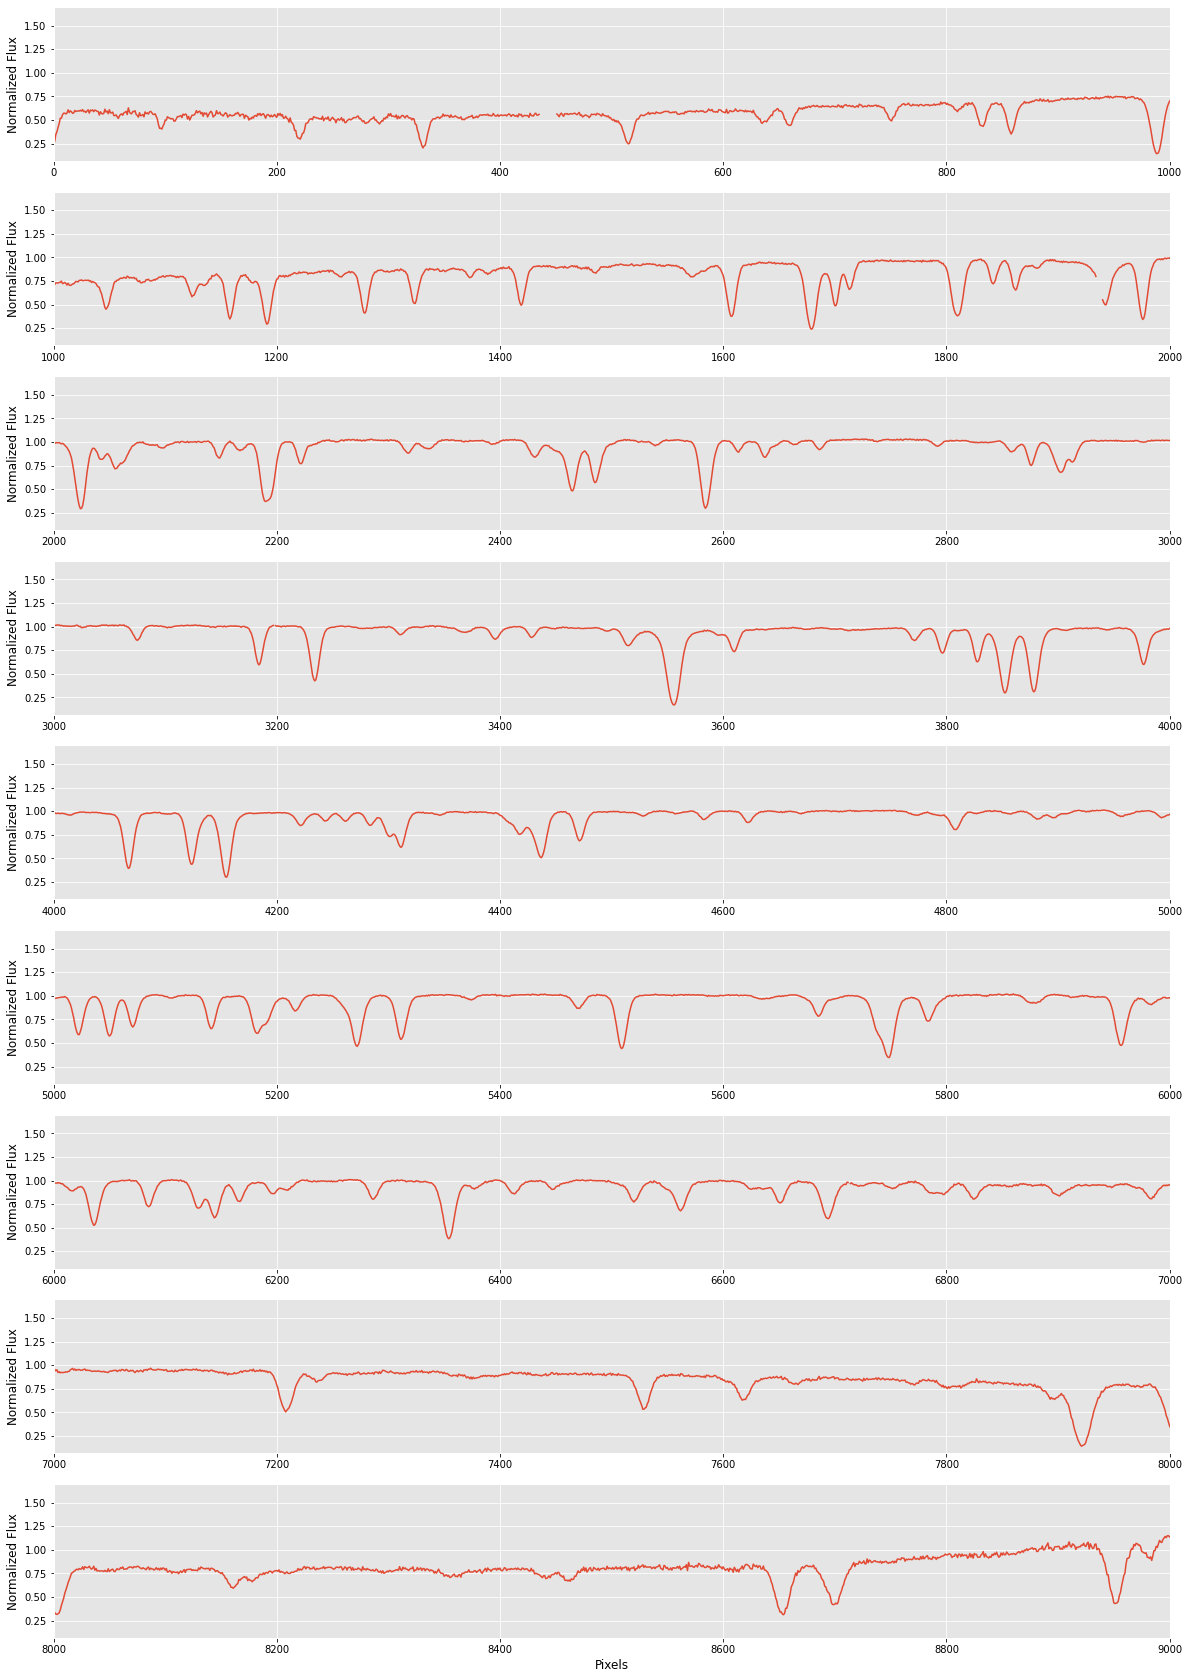

In [15]:
# Print List of Peak Findings
print('List of peak findings:',good_lines)

# Plot Peak Finding Lines 
fig, axs = plt.subplots(nrows=9,figsize=(20,30))
for i in range(9):
    axs[i].plot(correction)
    axs[i].plot(good_lines,np.repeat(1,len(good_lines)),'ro')
    axs[i].vlines(good_lines,0,1,color='r',alpha=0.4)
    axs[i].set_xlim(i*1000,(i+1)*1000)
    axs[i].set_ylabel('Normalized Flux')
axs[i].set_xlabel('Pixels')
plt.show()

In [16]:
# Fit Skewed Gaussian to the 112th Line as Test
pixrange = 15
linenum = 49

# (Arpita) Chunk/Schunk Work
schunk = correction[(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
upside = -schunk + 1
xchunk = np.arange(len(schunk))

# Skewed Gaussian Model 'x' and 'y' Variables to Use
skgauss_x = good_lines[linenum]+xchunk
skgauss_y = upside

# Create Skewed Gaussian Model Fit
mod = SkewedGaussianModel()
pars = mod.guess(skgauss_y, x=skgauss_x)
out = mod.fit(skgauss_y, pars, x=skgauss_x)

IndexError: list index out of range

In [ ]:
# Plot Skewed Gaussian Model Fit
plt.figure(figsize=(20,6))
plt.plot(skgauss_x, skgauss_y, 'o',ms=8,label='Data')
plt.plot(skgauss_x, out.best_fit,lw=3,label='Skewed Gaussian Fit '+str(linenum))
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')
plt.legend()

# Print Skewed Gaussian Parameters Report
print(out.fit_report(min_correl=0.25))

In [17]:
# Variable and List Settings
pixrange = 15
total_count = 0
filter_count = 0
centroid_list = []   

# Loop through all Lines
for linenum, val in enumerate(good_lines):
    
    # (Arpita) Chunk/Schunk Work
    schunk = correction[(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
    upside = -schunk + 1
    xchunk = np.arange(len(schunk))

    # Skewed Gaussian Model 'x' and 'y' Variables to Use
    skgauss_x = good_lines[linenum]+xchunk
    skgauss_y = upside
    
    # Convert to Wavelength Values
    wchunk = wave[order,(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]

    # Create Skewed Gaussian Model Fit
    mod = SkewedGaussianModel()
    pars = mod.guess(upside, x=wchunk)
    out = mod.fit(upside, pars, x=wchunk)

    # Find the Centroid
    height_xval = np.amax(out.best_fit, axis=0) # = amplitude
    lines_data = np.stack((skgauss_x, out.best_fit), axis=1)
    height_result = np.where(lines_data == height_xval) 
    index = height_result[0]
    centroid = pars['center'].value
    centroid_pixval = np.interp(centroid, wchunk, skgauss_x) # = (lines_data[index][0])[0] = height_yval
    
    # Find the Amplitude
    amplitude = height_xval
    
    # Create Skewed Gaussian Model Fit
    mod = SkewedGaussianModel()
    pars = mod.guess(upside, x=wchunk)
    out = mod.fit(upside, pars, x=wchunk)
    
    # Find Sigma (Pixels)
    mod2 = SkewedGaussianModel()
    pars2 = mod2.guess(skgauss_y, x=skgauss_x)
    out2 = mod2.fit(skgauss_y, pars2, x=skgauss_x)
    sigma = pars['sigma'].value
    
    # Find the Skewness
    get_skew = pd.DataFrame(out.best_fit).skew()
    skew = get_skew[0]
    
    # Bound for integration
    dats = np.stack((wchunk, upside), axis=1)
    
    FWHM = sigma * 2.3548
    min_window = centroid - (FWHM/2)
    max_window = centroid + (FWHM/2)
    
    # Find the Integrated Flux
    y_values = out.best_fit
    merged_list = [(wchunk[i], y_values[i]) for i in range(0, len(wchunk))]
    result1 = [i for i in merged_list if i[0] < max_window]
    result2 = [i for i in result1 if i[0] > min_window]
    list1, list2 = zip(*result2)
    
    int_flux = trapz(list2, dx=5)
        
    # Bounds Used to make sure Centroid within Range
    xmin_bound = np.amin(skgauss_x) + 10
    xmax_bound = np.amax(skgauss_x) - 10
    
    # Filter Quality Checks
    if (sigma >= 8) or (amplitude <= 0.1) or (amplitude >= 1) or (skew >= 1) or (skew <= -0.4) or (0 < skew < 0.02) or (int_flux < 0.1): 
        filter_count += 1
        continue 
        
    # Filter where Centroids not in Range of Graph
    if (round(centroid_pixval) not in range(xmin_bound, xmax_bound)):
        filter_count += 1
        continue
        
    # Filter Any Duplicate Lines
    centroid_list.append(centroid)
    for index, centroid in enumerate(centroid_list):
        if index == 0:
            continue  
        centroid_down = centroid_list[index-1]
        if (abs(centroid - centroid_down)) <= 0.05:
            centroid_list.remove(centroid)
            break 
    if centroid not in centroid_list:
        filter_count += 1
        continue
    
    # Plot Skew Gaussian Fit for Line
    fig,ax=plt.subplots(figsize=(20,6))
    plt.plot(list1, list2, 'o',ms=8,label='Data', color='r')
    plt.plot(wchunk, out.best_fit,lw=4,label='Skew Gaussian Fit '+str(total_count)+'\n'+'Centroid:'+str(centroid)+'\n'+'CentroidPixVal:'+str(centroid_pixval)+'\n'+'Amplitude:'+str(amplitude)+'\n'+'Sigma:'+str(sigma)+'\n'+'Skew:'+str(skew)+'\n'+'Integrated Flux:'+str(int_flux), color='#E25D6B')
    ax.ticklabel_format(useOffset=False)
    ax.vlines(centroid,0,1,color='#088F8F',linestyle='--',lw=3,label='Gaussian Centroid')
    ax.vlines(min_window,0,1,color='#0000FF',linestyle='--',lw=3,label='FWHM Min-Bound')
    ax.vlines(max_window,0,1,color='#0000FF',linestyle='--',lw=3,label='FWHM Max-Bound')
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Normalized Flux')
    plt.legend()
    
    # Add to Total Count of Fits
    total_count += 1
    
    
# Print Results
print('Total # of Spectral Skew-Gaussain Representations:', total_count)
print('Total # of \'Bad\' Fits Thrown Out:', filter_count)
print(list2)

Total # of Spectral Skew-Gaussain Representations: 0
Total # of 'Bad' Fits Thrown Out: 0


NameError: name 'list2' is not defined

In [18]:
# DATA CUBE FORMAT
# For each order (range 40 thru 110): Find all good lines and add to data cube
# 
# Reference File Name
#    Order 40
#       Line 2 
#          Centroid 4567.35
#          Centroid Pix Val 1245
#          Other Properties 
# File @ Time 
#    Order 
#       Corresponding Line (2)
#          Centroid 
#          Centroid Pix Val 
#          Property 
# etc...
#
#
#
#

In [ ]:
# Create Nested Dictionary of Values
start_time = time.time()
nested_dict = {}
for order_value in range(40, 111):
    # Get the Order (40-110)
    order = order_value
        
    # Replace NaN Values with Zero of Numpy Array for Wave and Flux
    x = np.nan_to_num(np.array(wave[order,:]))
    y = np.nan_to_num(np.array(flux[order,:]))
    pix_array = np.arange(flux.shape[1])

    # Set NaNs to zero
    flux[np.isnan(flux)] = 0
    wave[np.isnan(wave)] = 0

    # Combine 'x' and 'y' into Single Array
    order_data = np.stack((x, y), axis=1)

    # Blaze Correction
    unkfit, cs,chunks_x, chunks_y = chunked_continuum_fit(pix_array,flux[order,:],percentile_cut=90.0, nchunks=100, deg=7)
    model = SkewedGaussianModel()
    params = model.make_params(amplitude=2e5, center=4500, sigma=1000, gamma=1)
    result = model.fit(chunks_y, params, x=chunks_x)
    skew_blaze = np.interp(pix_array, chunks_x, result.best_fit)
    correction = flux[order,:]/skew_blaze
    
    # First Derivative of Blaze-Removed Spectrum (To Find Zero-Crossings)
    derivative = np.gradient(correction) 

    # Second Derivative of Blaze-Removed Spectrum (To Remove Most Noise)
    derivative2 = np.gradient(derivative) 

    # Smoothed First & Second Derivatives
    smooth_derivative = savgol_filter(derivative, 11, 5)
    smooth_derivative2 = savgol_filter(derivative2, 11, 5)

    # Third Derivative of Blaze-Removed Spectrum (To Remove Duplicate Points)
    derivative3 = np.gradient(smooth_derivative2) 

    # Sort List to Split into 3 Parts and Find Avg Value of Upper Part to determine 2nd Der 'Bump' Thresholds
    sortedlist_for2 = np.sort(smooth_derivative2)
    splitlist = np.array_split(sortedlist_for2, 3)

    # Find Zero Crossings
    zero_crossing1 = np.where((smooth_derivative2 > np.mean(splitlist[2])))[0] 
    zero_crossing2 = np.where(np.diff(np.signbit(derivative3)))
    zerolist1 = zero_crossing1.tolist()
    zerolist2 = np.array(zero_crossing2).tolist()
    zero_crossings = np.array(list(set(zerolist1).intersection(zerolist2[0]))) # final list of points!
    
    # Create List of Peak Findings and Sort List
    good_lines = []
    for zero_crossing in zero_crossings:
        # (Arpita) cut off pixels at very edge of detector
        if 20 < zero_crossing < 9000: 

            # (Arpita) Make sure first derivate is going from negative to positive
            slope = smooth_derivative[zero_crossing-1] - smooth_derivative[zero_crossing+1]

            # (Arpita) Im setting these numbers after experimenting with different slope cuts
            if -0.38 < slope < -0.01:
                good_lines.append(zero_crossing)
    good_lines.sort()

    # Delete Really Close-to-Each-Other Values
    for index, i in enumerate(good_lines):
        if good_lines[-1] == i:
            break

        i_up = good_lines[index+1]
        if ((i_up-i) < 18):
            good_lines.remove(i)
            good_lines.remove(i_up)
            
    # Loop through all Lines
    pixrange, total_count = 15, 0
    centroid_list = []   
    nested_dict['Order '+str(order)] = {}
    for linenum, val in enumerate(good_lines):
        
        # (Arpita) Chunk/Shunk Work
        schunk = correction[(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
        upside = -schunk + 1
        xchunk = np.arange(len(schunk))

        # Skewed Gaussian Model 'x' and 'y' Variables to Use
        skgauss_x = good_lines[linenum]+xchunk
        skgauss_y = upside

        # Convert to Wavelength Values
        wchunk = wave[order,(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
        wavelength_lines_data = np.stack((wchunk, out.best_fit), axis=1)

        # Create Skewed Gaussian Model Fit
        mod = SkewedGaussianModel()
        pars = mod.guess(upside, x=wchunk)
        out = mod.fit(upside, pars, x=wchunk)

        # Find the Centroid
        height_xval = np.amax(out.best_fit, axis=0) # = amplitude
        lines_data = np.stack((skgauss_x, out.best_fit), axis=1)
        height_result = np.where(lines_data == height_xval) 
        index = height_result[0]
        centroid = pars['center'].value
        centroid_pixval = np.interp(centroid, wchunk, skgauss_x) # = (lines_data[index][0])[0] = height_yval

        # Find the Normalized Amplitude
        amplitude = height_xval
        
        # Find Sigma (Pixels)
        mod2 = SkewedGaussianModel()
        pars2 = mod2.guess(skgauss_y, x=skgauss_x)
        out2 = mod2.fit(skgauss_y, pars2, x=skgauss_x)
        sigma = pars2['sigma'].value

        # Find the Skewness
        get_skew = pd.DataFrame(out.best_fit).skew()
        skew = get_skew[0]
        
        # Bound for integration
        dats = np.stack((wchunk, upside), axis=1)

        FWHM = sigma * 2.3548
        min_window = centroid - (FWHM/2)
        max_window = centroid + (FWHM/2)

        # Find the Integrated Flux
        y_values = out.best_fit
        merged_list = [(wchunk[i], y_values[i]) for i in range(0, len(wchunk))]
        result1 = [i for i in merged_list if i[0] < max_window]
        result2 = [i for i in result1 if i[0] > min_window]
        list1, list2 = zip(*result2)
        int_flux = trapz(list2, dx=5)

        # Bounds Used to make sure Centroid within Range
        xmin_bound = np.amin(skgauss_x) + 10
        xmax_bound = np.amax(skgauss_x) - 10

        # Filter Quality Checks
        if (sigma >= 8) or (amplitude <= 0.1) or (amplitude >= 1) or (skew >= 1) or (skew <= -0.4) or (int_flux < 0.1): 
            filter_count += 1
            continue 

        # Filter where Centroids not in Range of Graph
        if (round(centroid_pixval) not in range(xmin_bound, xmax_bound)):
            filter_count += 1
            continue

        # Filter Any Duplicate Lines
        centroid_list.append(centroid)
        for index, centroid in enumerate(centroid_list):
            if index == 0:
                continue  
            centroid_down = centroid_list[index-1]
            if (abs(centroid - centroid_down)) <= 0.05:
                centroid_list.remove(centroid)
                break 
        if centroid not in centroid_list:
            filter_count += 1
            continue

        
        # Append Nested Dictionary Values
        nested_dict['Order '+str(order)]['Line '+str(total_count)] = {}
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['centroid'] = centroid
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['centroid_pixval'] = centroid_pixval
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['amplitude'] = amplitude
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['sigma'] = sigma
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['skew'] = skew
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['int_flux'] = int_flux
        
        # Add to Total Count of Lines
        total_count += 1

print('Completed in ',(time.time() - start_time),' seconds')

In [ ]:
# Save the Nested Dictionary
#OLD np.save('main_datalist.npy', nested_dict) 
np.save('noon_t0.npy', nested_dict) 

# Read and Print the Nested Dictionary from Saved File
#OLD main_datalist = np.load('main_datalist.npy',allow_pickle='TRUE').item()
noon_t0_datalist = np.load('noon_t0.npy',allow_pickle='TRUE').item()

# Fin!
print(noon_t0_datalist)

In [20]:
 # Create Time Axis
ref_file_time = '20210509T195226' 
time_folder = {}
noon_t0_datalist = np.load('noon_t0.npy',allow_pickle='TRUE').item()
time_folder['Time '+str(ref_file_time)] = noon_t0_datalist

noon_t0_datalist = np.load('noon_t0.npy',allow_pickle='TRUE').item()
ref_file_time = '20210509T195226' 

# Save Final Dictionary @ Checkpoint
np.save('data_cube_v2.0.0.npy', time_folder) 

In [ ]:
start_time = time.time()

# Prepare Directory
file_dir = os.listdir('/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/')
NEID_Sun = [s for s in file_dir if 'neid' in s]
NEID_Sun.sort()

# Load Current Cube
time_folder = np.load('data_cube_v2.0.0.npy',allow_pickle='TRUE').item()
ref_file_time = '20210509T195226' 

# Loop through all Files
for file in NEID_Sun:
    
    # Get the Date-Time for File
    file.replace('.fits', '')
    file_time = (file.split('_',1)[1]).partition('.')[0]
    
    # Check if already Looped 
    completed_times = []
    for timeval in time_folder:
        timeval = timeval.replace('Time ', '')
        completed_times.append(timeval)
    
    if file_time in completed_times:
        continue
        
    # Open the FITS File
    hdul = fits.open('/xdisk/cbender/cbender/sandbox/solar_data_noon_half_hour/'+str(file))
        
    # Get Flux and Wave Data
    flux = hdul['SCIFLUX'].data
    wave = hdul['SCIWAVE'].data

    # Loop through Orders 40-110
    time_folder['Time '+str(file_time)] = {}
    for order in range(40,111):
        # Replace NaN Values with Zero of Numpy Array for Wave and Flux
        x = np.nan_to_num(np.array(wave[order,:]))
        y = np.nan_to_num(np.array(flux[order,:]))
        pix_array = np.arange(flux.shape[1])

        # Set NaNs to zero
        flux[np.isnan(flux)] = 0
        wave[np.isnan(wave)] = 0

        # Combine 'x' and 'y' into Single Array
        order_data = np.stack((x, y), axis=1)

        # Blaze Correction
        unkfit, cs,chunks_x, chunks_y = chunked_continuum_fit(pix_array,flux[order,:],percentile_cut=90.0, nchunks=100, deg=7)
        model = SkewedGaussianModel()
        params = model.make_params(amplitude=2e5, center=4500, sigma=1000, gamma=1)
        result = model.fit(chunks_y, params, x=chunks_x)
        skew_blaze = np.interp(pix_array, chunks_x, result.best_fit)
        correction = flux[order,:]/skew_blaze
        
        # Get Reference File Lines for Order
        ref_lines = time_folder['Time '+str(ref_file_time)]['Order '+str(order)]
        
        # Loop through each Reference Line and find Matching Fit
        time_folder['Time '+str(file_time)]['Order '+str(order)] = {}
        for index, ref_line in enumerate(ref_lines): 
            # Reference Centroid (in Pixels)
            ref_centroid_pixval = ref_lines['Line '+str(index)]['centroid_pixval'] - 15
            rounded_ref_centroid_pixval = int(round(ref_centroid_pixval))
            
            # (Arpita) Chunk/Shunk Work
            schunk = correction[(rounded_ref_centroid_pixval-pixrange):(rounded_ref_centroid_pixval+pixrange)]
            upside = np.nan_to_num(-schunk + 1)
            xchunk = np.arange(len(schunk))

            # Skewed Gaussian Model 'x' and 'y' Variables to Use
            skgauss_x = rounded_ref_centroid_pixval+xchunk
            skgauss_y = upside

            # Convert to Wavelength Values
            wchunk = wave[order,(rounded_ref_centroid_pixval-pixrange):(rounded_ref_centroid_pixval+pixrange)]

            # Create Skewed Gaussian Model Fit
            mod = SkewedGaussianModel()
            pars = mod.guess(upside, x=wchunk)
                
            try:
                out = mod.fit(upside, pars, x=wchunk)
            except ValueError:
                continue
                
            
            # Find the Centroid
            height_xval = np.amax(out.best_fit, axis=0) # = amplitude
            lines_data = np.stack((skgauss_x, out.best_fit), axis=1)
            height_result = np.where(lines_data == height_xval) 
            centroid = pars['center'].value
            centroid_pixval = np.interp(centroid, wchunk, skgauss_x) # = (lines_data[index][0])[0] = height_yval

            # Find the Normalized Amplitude
            amplitude = height_xval

            # Find Sigma (Pixels)
            mod2 = SkewedGaussianModel()
            pars2 = mod2.guess(skgauss_y, x=skgauss_x)
            out2 = mod2.fit(skgauss_y, pars2, x=skgauss_x)
            sigma = pars2['sigma'].value

            # Find the Skewness
            get_skew = pd.DataFrame(out.best_fit).skew()
            skew = get_skew[0]
        
            # Bound for integration
            dats = np.stack((wchunk, upside), axis=1)
            FWHM = sigma * 2.3548
            min_window = centroid - (FWHM/2)
            max_window = centroid + (FWHM/2)

            # Find the Integrated Flux
            y_values = out.best_fit
            merged_list = [(wchunk[i], y_values[i]) for i in range(0, len(wchunk))]
            result1 = [i for i in merged_list if i[0] < max_window]
            result2 = [i for i in result1 if i[0] > min_window]
            list1, list2 = zip(*result2)
            int_flux = trapz(list2, dx=5)
            
            # Append Nested Dictionary Values 
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)] = {}
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['centroid'] = centroid
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['centroid_pixval'] = centroid_pixval
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['amplitude'] = amplitude
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['sigma'] = sigma
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['skew'] = skew 
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['int_flux'] = int_flux 
            
        # Save File Data to Dictionary Checkpoint
        if order == 110:
            np.save('data_cube_v2.0.0.npy', time_folder) 
                                               
print('Completed in ',(time.time() - start_time),' seconds')